#
the best is to run this .py file as a script, if you want you can also to convert it to a jupyter notebook with
jupytext --to notebook merfish.py
When runnning the notebook the working directory should be the project root folder otherwise the data paths will be
not found (use os.chdir(<project root path>)

In [1]:
import os
os.chdir('../../')
os.getcwd()

'/Users/macbook/embl/projects/basel/ome-ngff-tables-prototype'

In [2]:
##
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import json
import matplotlib
import matplotlib.pyplot as plt
import os
import pathlib
import math

In [3]:
plt.style.use("dark_background")

In [4]:
##
output_dir = "notebooks/merfish/output"
os.makedirs(output_dir, exist_ok=True)

In [5]:
##
class BoundingBox:
    pass

In [6]:
small_bb = BoundingBox()
small_bb.x0 = 2000
small_bb.x1 = 2400
small_bb.y0 = 4800
small_bb.y1 = 5200

In [7]:
bb = BoundingBox()
bb.x0 = 1154
bb.x1 = 3172
bb.y0 = 4548
bb.y1 = 6566

#

In [8]:
# loads point data
df = pd.read_csv("notebooks/merfish/data/Allen_MERFISH_spots_with_anatomy.csv")
plt.figure(figsize=(10, 10))
points_bb = bb
df = df[
    (df["x_um"] > points_bb.x0)
    & (df["x_um"] < points_bb.x1)
    & (df["y_um"] > points_bb.y0)
    & (df["y_um"] < points_bb.y1)
]
xy = df[["x_um", "y_um"]].to_numpy()
a_points = ad.AnnData(xy)
# a_points.obsm["spatial"] = xy
a_points.obsm["cell_type"] = df["layer"].to_numpy()
# a_points.obs.columns = ["0"]
a_points.write_h5ad(os.path.join(output_dir, "points.h5ad"))

<Figure size 720x720 with 0 Axes>

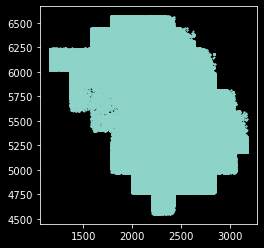

In [9]:
##
plt.figure()
plt.scatter(xy[:, 0], xy[:, 1], s=1)
plt.gca().set_aspect("equal")
plt.show()

In [10]:
##
def plot_single_molecule_anndata(adata: ad.AnnData, ax=None):
    xy = adata.X
    c = adata.obsm["cell_type"]
    if ax is None:
        plt.figure(figsize=(10, 10))
        cax = plt.gca()
    else:
        cax = ax
    all_types = list(set(c))
    cax.scatter(xy[:, 0], xy[:, 1], s=1, c=[all_types.index(cc) for cc in c])
    cax.set_aspect("equal")
    if ax is None:
        plt.show()

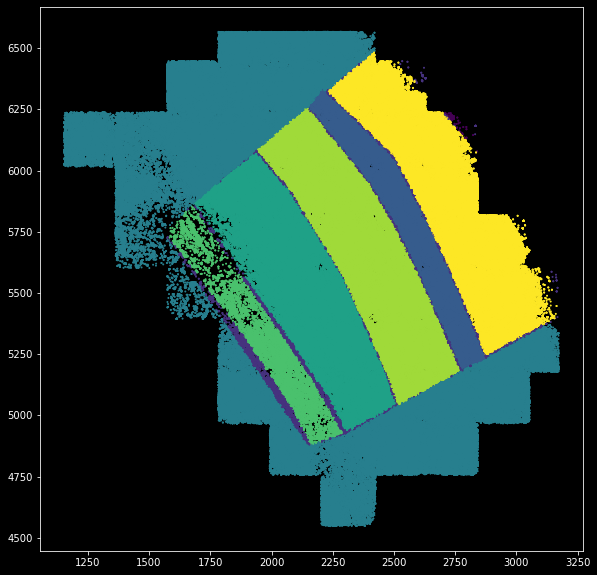

In [11]:
plot_single_molecule_anndata(a_points)

In [12]:
##
# loads single cell masks data
df = pd.read_csv("notebooks/merfish/data/fixed_1001844875.csv")
df.drop(columns=[df.columns[0], df.columns[1]], inplace=True)
df["radius"] = df["area"].apply(lambda x: math.sqrt(x / math.pi))
genes = df.columns.tolist()
genes = genes[: genes.index("area")]
xy = df[["x_um", "y_um"]].to_numpy()

In [13]:
a_cells = ad.AnnData(X=df[genes])
a_cells.obsm["spatial"] = xy
a_cells.obsm["region_radius"] = df["radius"].to_numpy()
a_cells.write_h5ad(os.path.join(output_dir, "cells.h5ad"))

/Users/macbook/miniconda3/envs/39/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
##
def plot_shape_masks_anndata(adata: ad.AnnData, ax=None):
    if ax is None:
        plt.figure(figsize=(10, 10))
        cax = plt.gca()
    else:
        cax = ax
    xy = adata.obsm["spatial"]
    radius = adata.obsm["region_radius"]
    patches = []
    for (x, y), r in zip(xy, radius):
        if bb.x0 - r < x < bb.x1 + r and bb.y0 - r < y < bb.y1 + r:
            patch = matplotlib.patches.Circle(
                (x, y), r, color=np.append(np.random.rand(3), 0.3)
            )
            patches.append(patch)
    p = matplotlib.collections.PatchCollection(patches, match_original=True)
    cax.add_collection(p)
    cax.set(xlim=(bb.x0, bb.x1), ylim=(bb.y0, bb.y1))
    cax.set_aspect("equal")
    if ax is None:
        plt.show()

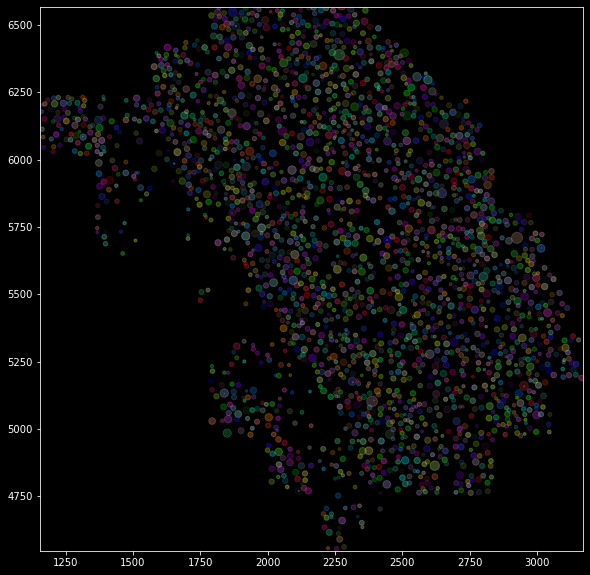

In [15]:
plot_shape_masks_anndata(a_cells)

#

In [16]:
# generate the raster image
import datashader
import colorcet

In [17]:
df = pd.read_csv("notebooks/merfish/data/Allen_MERFISH_spots_with_anatomy.csv")
df["datashader"] = np.array([1] * len(df))
raster_w = 600
raster_h = 600
cvs = datashader.Canvas(plot_width=raster_w, plot_height=raster_h)
# agg = cvs.points(df, x="x_um", y="y_um", agg=datashader.any())
agg = cvs.points(df, x="x_um", y="y_um", agg=datashader.count())
# img = datashader.tf.shade(agg)
# raster = img.to_numpy()
raster = agg.to_numpy()
raster = raster.astype(np.float64)
raster /= raster.max()
# raster = np.flipud(raster)
# raster = np.log(1 + raster)

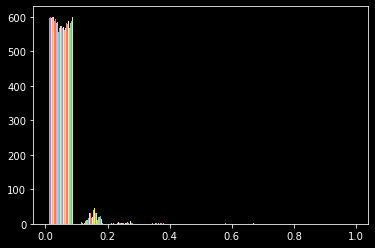

In [18]:
plt.figure()
len(df)
# plt.hist(raster.flatten())
plt.hist(raster)
# plt.hist(raster.flatten()[raster.flatten() >1000], bins=1000)
plt.show()

In [19]:
##
# let's manually adjust the levels to make the image brighter in this example
raster = np.clip(raster, a_min=0.0, a_max=0.2)
raster *= 5
#
# plt.figure()
# plt.imshow(raster, origin='lower')
# plt.xlim([400, 425])
# plt.ylim([175, 200])
# plt.show()

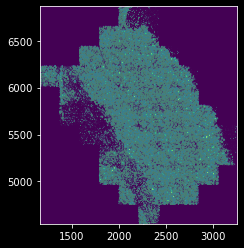

In [20]:
##
plt.figure()
plt.imshow(
    raster,
    extent=(df["x_um"].min(), df["x_um"].max(), df["y_um"].min(), df["y_um"].max()),
    origin="lower",
)
plt.scatter(df["x_um"], df["y_um"], s=1, alpha=0.01)
plt.show()

In [21]:
##
min_x = df["x_um"].min()
min_y = df["y_um"].min()
max_x = df["x_um"].max()
max_y = df["y_um"].max()

In [22]:
raster_bb = BoundingBox()
raster_bb.x0 = int((bb.x0 - min_x) / (max_x - min_x) * raster_w)
raster_bb.x1 = int((bb.x1 - min_x) / (max_x - min_x) * raster_w)
raster_bb.y0 = int((bb.y0 - min_y) / (max_y - min_y) * raster_h)
raster_bb.y1 = int((bb.y1 - min_y) / (max_y - min_y) * raster_h)
print(
    f"raster_bb.x0 = {raster_bb.x0}, raster_bb.x1 = {raster_bb.x1}, raster_bb.y0 = {raster_bb.y0}, raster_bb.y1 = {raster_bb.y1}"
)

raster_bb.x0 = 0, raster_bb.x1 = 575, raster_bb.y0 = 0, raster_bb.y1 = 522


In [23]:
# raster_crop = np.flipud(np.flipud(raster)[raster_bb.y0 : raster_bb.y1, raster_bb.x0 : raster_bb.x1])
raster_crop = raster[raster_bb.y0 : raster_bb.y1, raster_bb.x0 : raster_bb.x1]
print(raster_crop.shape)

(522, 575)


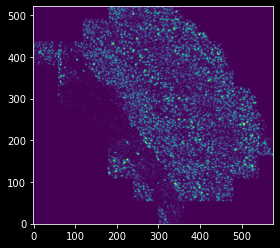

In [24]:
plt.figure()
plt.imshow(raster_crop, origin="lower")
plt.show()
##
translation = np.array([bb.x0, bb.y0])
# assert bb.x1 - bb.x0 == bb.y1 - bb.y0
# assert raster_w == raster_h
scale_factor_x = (max_x - min_x) / raster_w
scale_factor_y = (max_y - min_y) / raster_h
scale_factors = np.array([scale_factor_x, scale_factor_y])
# wrong
# scale_factor = (bb.x1 - bb.x0) / raster_w
##
np.save(os.path.join(output_dir, "image"), raster_crop)

In [25]:
d = {}
d["translation_x"] = float(translation[0])
d["translation_y"] = float(translation[1])
d["scale_factor_x"] = scale_factor_x
d["scale_factor_y"] = scale_factor_y
with open(os.path.join(output_dir, "image_transform.json"), "w") as outfile:
    json.dump(d, fp=outfile)

In [26]:
##
print(f"translation = {translation}, scale_factor = {scale_factors}")
x0 = translation[0]
y0 = translation[1]
x1 = translation[0] + raster.shape[1] * scale_factor_x
y1 = translation[1] + raster.shape[0] * scale_factor_y
extent = (x0, x1, y0, y1)
print(extent)

translation = [1154 4548], scale_factor = [3.50777513 3.86311352]
(1154, 3258.665080136381, 4548, 6865.868111728963)


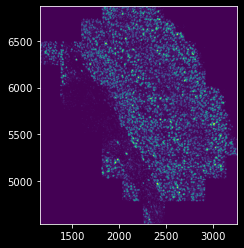

In [27]:
plt.figure()
plt.imshow(raster_crop, extent=extent, origin="lower")
plt.show()
##

In [28]:
# first translation, then scaling
def plot_raster(
    raster: np.ndarray, translation: np.array, scale_factors: np.array, ax=None
):
    assert len(translation) == 2
    # grayscale image or rgb/rgba
    assert (
        len(raster.shape) == 2 or len(raster.shape) == 3 and raster.shape[2] in [3, 4]
    )
    if ax is None:
        plt.figure(figsize=(10, 10))
        cax = plt.gca()
    else:
        cax = ax
    x0 = translation[0]
    y0 = translation[1]
    x1 = translation[0] + raster.shape[1] * scale_factors[0]
    y1 = translation[1] + raster.shape[0] * scale_factors[1]
    extent = (x0, x1, y0, y1)
    cax.imshow(
        raster_crop,
        extent=extent,
        cmap=plt.cm.get_cmap("gray"),
        alpha=0.4,
        origin="lower",
    )
    if ax is None:
        plt.show()

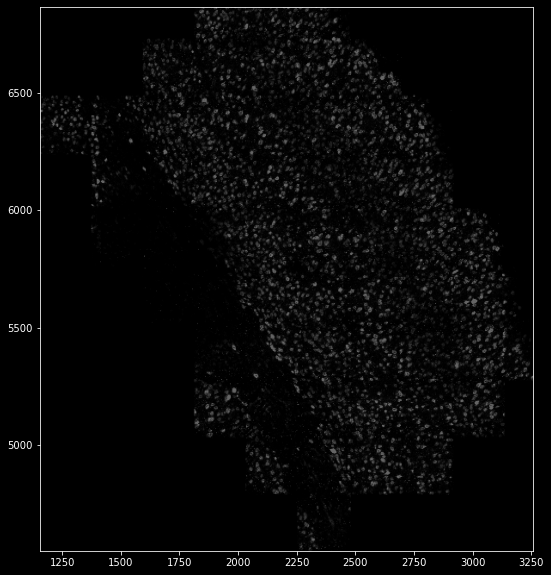

{'type': 'GeometryCollection',
 'geometries': [{'type': 'Polygon',
   'name': 'L1',
   'coordinates': [[[2435.069566, 6500.284703],
     [2476.390162, 6535.178868],
     [2534.993939, 6471.307336],
     [2743.287325, 6256.796237],
     [2892.512438, 6045.393994],
     [3110.132394, 5597.718655],
     [3175.960311, 5399.368749],
     [3130.896017, 5374.899385],
     [3077.489401, 5557.30352],
     [2850.542875, 6011.196572],
     [2712.19876, 6214.826674],
     [2493.024376, 6434.001058],
     [2435.069566, 6500.284703]]]},
  {'type': 'Polygon',
   'name': 'L4',
   'coordinates': [[[2099.296063, 6218.987584],
     [2143.972428, 6257.045228],
     [2145.859029, 6257.045228],
     [2146.338866, 6256.459168],
     [2151.558392, 6260.866921],
     [2210.003484, 6332.509292],
     [2221.323093, 6321.189682],
     [2222.09221, 6320.430889],
     [2259.341867, 6351.887251],
     [2357.789117, 6236.588669],
     [2668.674769, 5824.665181],
     [2827.226451, 5490.463105],
     [2914.2115, 5257.

In [29]:
plot_raster(raster, translation=translation, scale_factors=scale_factors)
##
# polygon information
layers = json.load(open("notebooks/merfish/data/Allen_MERFISH_Layers.geojson", "r"))
layers

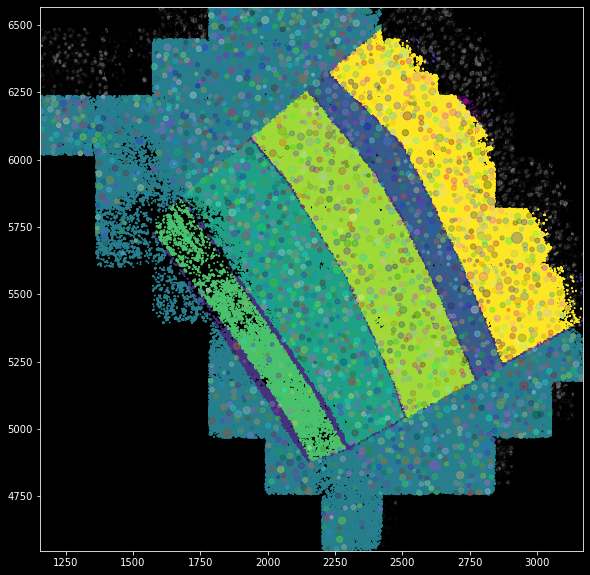

In [30]:
##
# I think there is a bug here and things are not plotted aligned, but things are aligned in the napari viewer,
# that is our real goal
plt.figure(figsize=(10, 10))
ax = plt.gca()
plot_single_molecule_anndata(a_points, ax)
plot_shape_masks_anndata(a_cells, ax)
plot_raster(raster, translation=translation, scale_factors=scale_factors, ax=ax)
plt.show()

In [31]:
##
brain_layers = {}
for layer in layers["geometries"]:
    assert layer["type"] == "Polygon"
    name = layer["name"]
    coordinates = np.array(layer["coordinates"])
    coordinates = np.squeeze(coordinates, 0)
    brain_layers[name] = coordinates

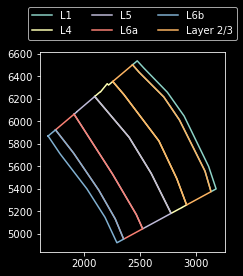

In [32]:
##
plt.figure()
for layer, coordinates in brain_layers.items():
    plt.plot(coordinates[:, 0], coordinates[:, 1])
plt.gca().set_aspect("equal")
plt.legend(
    [layer for layer in brain_layers.keys()],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=3,
)
plt.tight_layout()
plt.show()

In [33]:
##
a_polygon = ad.AnnData(None, obs=list(brain_layers.keys()))
a_polygon.obs.columns = ["layer"]
a_polygon.obs["vertices"] = list(brain_layers.values())
# temporary, inefficient arbitrary way of storing the coordinates
a_polygon.obs["vertices"] = a_polygon.obs["vertices"].apply(lambda x: repr(x))
a_polygon.write_h5ad(os.path.join(output_dir, "polygons.h5ad"))